# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.models import resnet18

from torchsummary import summary
from tqdm import tqdm

In [4]:
from Modules.data import cifiar_data_loader
#from Modules.models.resnet import ResNet18 as Net

#from Modules.models.torchvision_resnet import Net

from Modules.train.train_eval import train, test
from Modules.utility import visulization
from Modules.grad_cam.gradcam import GradCAM, GradCAMpp
from Modules.grad_cam.utility import visualize_cam

In [5]:
Net = resnet18

# Data loader

In [6]:
my_args = {'pin_memory' : False, 'num_workers': 1}
train_loader, test_loader = cifiar_data_loader.get_dataloder(args=my_args)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Visualization

In [7]:
it = iter(train_loader)

In [8]:
images, labels = it.next()

In [9]:
idx_to_class = {train_loader.dataset.class_to_idx[x] : x for x in train_loader.dataset.class_to_idx}

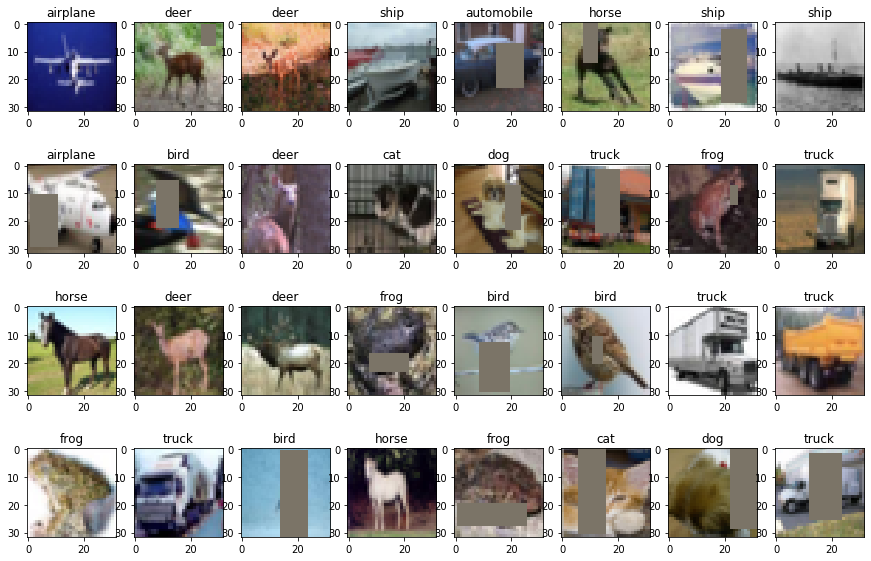

In [10]:
visulization.display_images(images, labels, idx_to_class)

# Network

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(pretrained=True, ).to(device)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10)
model = model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

# Train Phase

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [13]:
# for param in model.parameters():
#     print(param.requires_grad)
#     #param.requires_grad = True

In [14]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

total_epochs = 1
for i in range(total_epochs):
    train(model, device, train_loader, optimizer, i, train_losses, train_acc)
    test(model, device, test_loader,  test_losses, test_acc)

0 loss : 1.1368043422698975 acc : 0.5625: 100%|██████████| 1563/1563 [00:33<00:00, 44.52it/s] 


Acc :  55.66


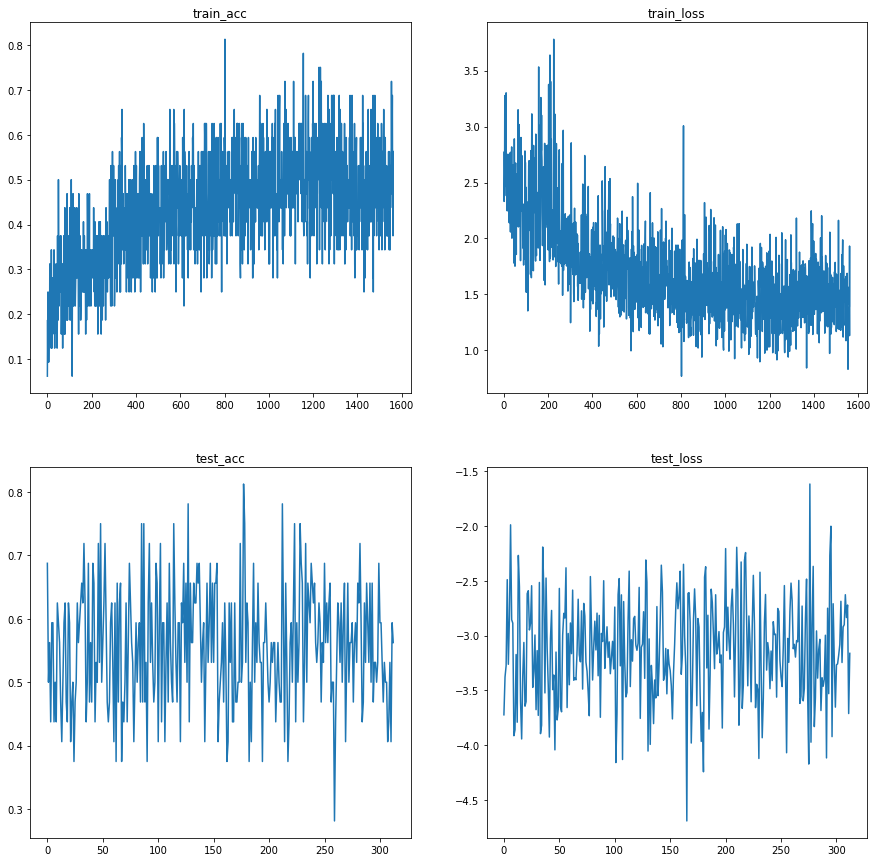

In [15]:
visulization.display_graphs(train_losses, test_losses, train_acc, test_acc)

# GradCam

In [16]:
model.eval()
gradcam  = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer3')
#gradcam_pp = GradCAMpp.from_config(model_type='resnet', arch=model, layer_name='layer4')

In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

torch.Size([1, 10])
tensor(2.7441, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


/home/gauravp/anaconda3/envs/kerasretina/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


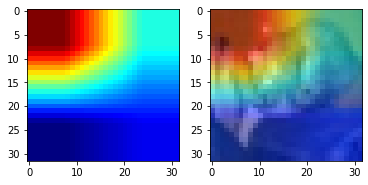

torch.Size([1, 10])
tensor(4.3401, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


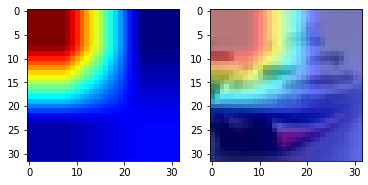

torch.Size([1, 10])
tensor(3.1929, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


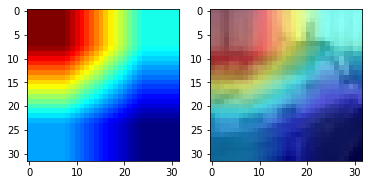

torch.Size([1, 10])
tensor(4.2521, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


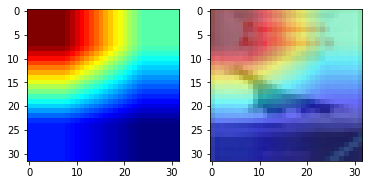

torch.Size([1, 10])
tensor(6.4846, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


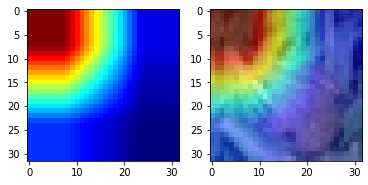

torch.Size([1, 10])
tensor(3.3626, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


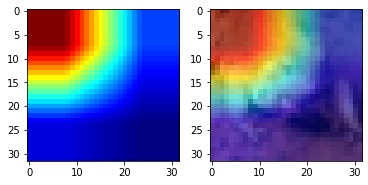

torch.Size([1, 10])
tensor(3.7131, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


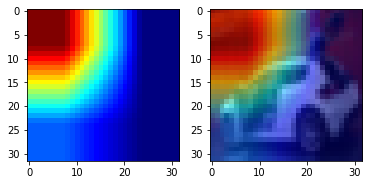

torch.Size([1, 10])
tensor(4.9402, device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 256, 2, 2])


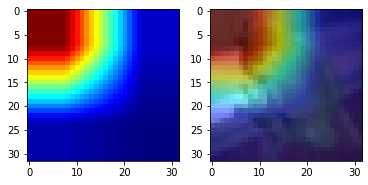

In [18]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)

for i in range(8):
        
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    input_img = images[i]
    input_img = np.expand_dims(input_img, 0)
    input_img = torch.tensor(input_img)
    input_img = input_img.to(device)

    mask, _ = gradcam(input_img)
    input_img = denormalize(input_img, mean, std)

    heatmap, result = visualize_cam(mask, input_img)
    
    fig, ax = plt.subplots(1, 2)
    tmp_img = np.array(heatmap)
    tmp_img = tmp_img.transpose([1, 2, 0])
    ax[0].imshow(tmp_img)
    
    tmp_img = np.array(result)
    tmp_img = tmp_img.transpose([1, 2, 0])
    ax[1].imshow(tmp_img)
    plt.show()